<a href="https://colab.research.google.com/github/fwilhelmy/IFT6135-2025/blob/main/HW1_2025/assignment1_release/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In [2]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MessageError: Error: credential propagation was unsuccessful

In [6]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135/HW1_2025/assignment1_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [1]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import generate_plots, seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [3]:
import unittest
import testy
suite = unittest.TestLoader().loadTestsFromModule(testy)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (testy.TestLinear.test_linear_attributes) ... ok
test_linear_forward (testy.TestLinear.test_linear_forward) ... ok
test_activation (testy.TestMLP.test_activation) ... ok
test_forward (testy.TestMLP.test_forward) ... ok
test_mlp (testy.TestMLP.test_mlp) ... ok
test_mixer_block (testy.TestMLPMixer.test_mixer_block) ... ok
test_mlpmixer (testy.TestMLPMixer.test_mlpmixer) ... ok
test_patch_emb (testy.TestMLPMixer.test_patch_emb) ... ok
test_basic_block (testy.TestResNet.test_basic_block) ... ok
test_basic_block2 (testy.TestResNet.test_basic_block2) ... ok
test_resnet (testy.TestResNet.test_resnet) ... ok
test_ce_loss (testy.TestUtils.test_ce_loss) ... ok

----------------------------------------------------------------------
Ran 12 tests in 1.113s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [4]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlp'  # [mlp, resnet18, mlpmixer]
  model_config: str = "./model_configs/mlp.json" # path to model config json file

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 15
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  logdir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  device: str = 'cuda'
  visualize : bool = False
  print_every: int = 80

In [5]:
# Main code entry. Train the model and save the logs
from main import train, evaluate
def main_entry(args):
    # Check for the device
    if (args.device == "cuda") and not torch.cuda.is_available():
        warnings.warn(
            "CUDA is not available, make that your environment is "
            "running on GPU (e.g. in the Notebook Settings in Google Colab). "
            'Forcing device="cpu".'
        )
        args.device = "cpu"

    if args.device == "cpu":
        warnings.warn(
            "You are about to run on CPU, and might run out of memory "
            "shortly. You can try setting batch_size=1 to reduce memory usage."
        )

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)

    # Load model
    print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    print(f'########## {args.model.upper()} CONFIG ################')
    for key, val in model_config.items():
        print(f'{key}:\t{val}')
    print('############################################')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)

    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )

    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []

    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    for epoch in range(args.epochs):
        tqdm.write(f"====== Epoch {epoch} ======>")
        loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)

    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )
    print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")

    # Save log if logdir provided
    if args.logdir is not None:
        print(f'Writing training logs to {args.logdir}...')
        os.makedirs(args.logdir, exist_ok=True)
        with open(os.path.join(args.logdir, 'results.json'), 'w') as f:
            f.write(json.dumps(
                {
                    "train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accs": train_accs,
                    "valid_accs": valid_accs,
                    "test_loss": test_loss,
                    "test_acc": test_acc
                },
                indent=4,
            ))

        # Visualize
        if args.visualize and args.model in ['resnet18', 'mlpmixer']:
            model.visualize(args.logdir)


In [6]:
def run_experiment(title, configs):
    for name in configs:
        config = configs[name]
        main_entry(config)
        generate_plots([config.logdir], [name], config.logdir)

    generate_plots([configs[x].logdir for x in configs], configs.keys(), f"results/{title}")

# Experiment 1

For the MLP architecture, investigate the effect of the choice of non-linearity while keeping the other hyperparameters the same as the default. You are expected to provide four figures corresponding to training loss, validation loss, training accuracy, and validation accuracy, where the x-axis is the number of epochs. For each figure, use the legend to denote the non-linearity being used. Conclude which non-linearity is the best and give your explanation. Optionally, we provide the plotting utility function in utils.py

In [8]:
experiment1 = {
    "mlp_relu": Arguments(logdir="results/experiment1/mlp_relu", model='mlp', model_config='model_configs/mlp/mlp_relu.json', epochs=10),
    "mlp_sigmoid": Arguments(logdir="results/experiment1/mlp_sigmoid", model='mlp', model_config='model_configs/mlp/mlp_sigmoid.json', epochs=10),
    "mlp_tanh": Arguments(logdir="results/experiment1/mlp_tanh", model='mlp', model_config='model_configs/mlp/mlp_tanh.json', epochs=10),
}

run_experiment("experiment1", experiment1)

C:\Users\fwilh\AppData\Local\Temp\ipykernel_29408\4235923879.py:6: UserWarning: CUDA is not available, make that your environment is running on GPU (e.g. in the Notebook Settings in Google Colab). Forcing device="cpu".
  warnings.warn(
C:\Users\fwilh\AppData\Local\Temp\ipykernel_29408\4235923879.py:14: UserWarning: You are about to run on CPU, and might run out of memory shortly. You can try setting batch_size=1 to reduce memory usage.
  warnings.warn(


Build model MLP...
Loading model config from model_configs/mlp/mlp_relu.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	relu
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.45333
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.84040
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.79643
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.54359
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.66979
== [TRAIN] Epoch: 0, Accuracy: 0.365 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.70092
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.424 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.62570
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.60908
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.59910
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.69408
[TRAIN] Epoch: 1, Iter: 320, Loss: 1.60318
== [TRAIN] Epoch: 1, Accuracy: 0.438 ==>
[VAL] Epoch: 1, Iter: 0, Los

KeyboardInterrupt: 

In [ ]:
!zip -r experiment1.zip results/experiment1

# Experiment 2 

For the ResNet18 architecture, investigate the effect of learning rate with the Adam optimizer. Perform experiments with learning rates of 0.1, 0.01, 0.001, 0.0001, 0.00001. Provide the figures and explain your findings.

In [ ]:
experiment2 = {
    "resnet18_lr_1e-1": Arguments(logdir="results/experiment2/resnet18_lr_1e-1", model='resnet18', model_config='assignment/model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-1),
    "resnet18_lr_1e-2": Arguments(logdir="results/experiment2/resnet18_lr_1e-2", model='resnet18', model_config='assignment/model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-2),
    "resnet18_lr_1e-3": Arguments(logdir="results/experiment2/resnet18_lr_1e-3", model='resnet18', model_config='assignment/model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-3),
    "resnet18_lr_1e-4": Arguments(logdir="results/experiment2/resnet18_lr_1e-4", model='resnet18', model_config='assignment/model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-4),
    "resnet18_lr_1e-5": Arguments(logdir="results/experiment2/resnet18_lr_1e-5", model='resnet18', model_config='assignment/model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-5),
}

run_experiment("experiment2", experiment2)

In [ ]:
!zip -r experiment2.zip results/experiment2

# Experiment 3

For MLPMixer, investigate the effect of patch size. No recommended values are given, and you are expected to run at least 3 experiments. Remember there are only a few valid values for patch size for the given image size. Please provide figures and explain your findings. Also explain in text the effect on the number of model parameters and running time.

C:\Users\fwilh\AppData\Local\Temp\ipykernel_29408\4235923879.py:6: UserWarning: CUDA is not available, make that your environment is running on GPU (e.g. in the Notebook Settings in Google Colab). Forcing device="cpu".
  warnings.warn(
C:\Users\fwilh\AppData\Local\Temp\ipykernel_29408\4235923879.py:14: UserWarning: You are about to run on CPU, and might run out of memory shortly. You can try setting batch_size=1 to reduce memory usage.
  warnings.warn(


Build model MLPMIXER...
Loading model config from model_configs/mlpmixer/mlpmixer_patch2.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	2
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2376458 total parameters, of which 2376458 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.44971
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.72474
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.46766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.40507
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.43083
== [TRAIN] Epoch: 0, Accuracy: 0.419 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.38753
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.502 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.17286
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.29201
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.39390
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.10111
[TRAIN] Epoch: 1, Iter: 320, Loss: 1.42790
== [TRAIN] Epoch: 1, A

FileNotFoundError: [Errno 2] No such file or directory: 'results/experiment3_mlpmixer_patch_size\\train_accs.png'

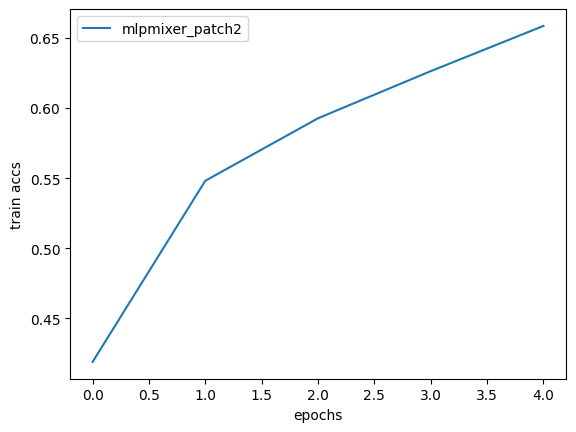

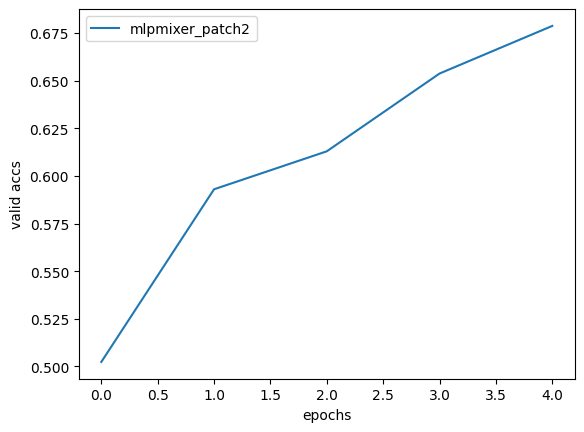

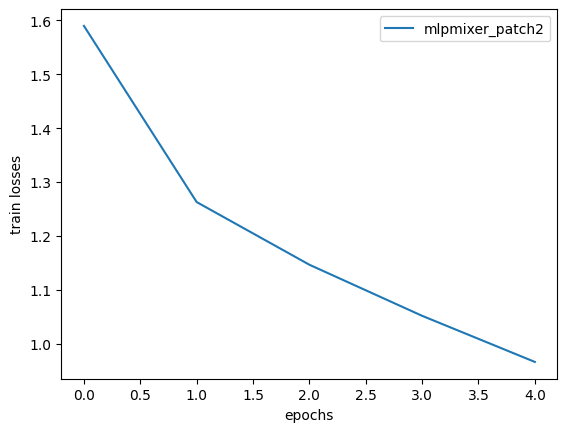

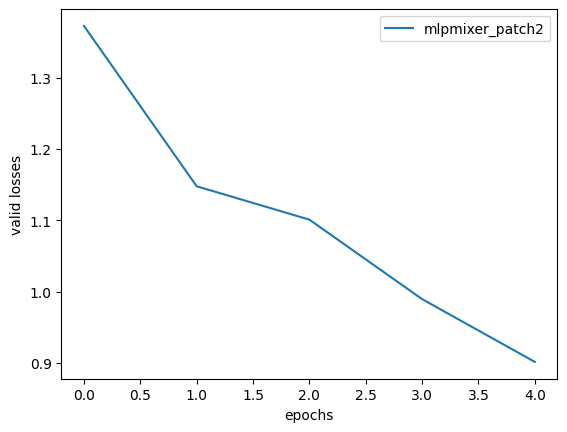

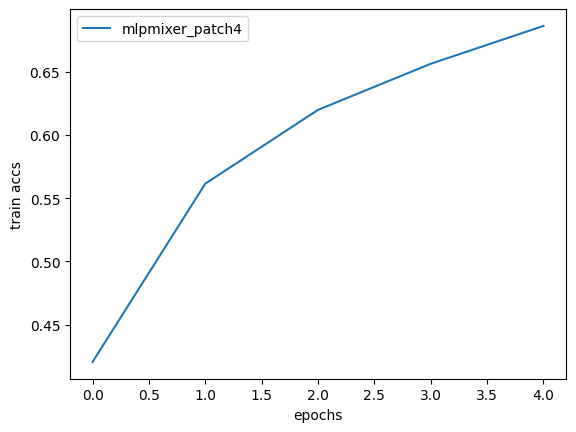

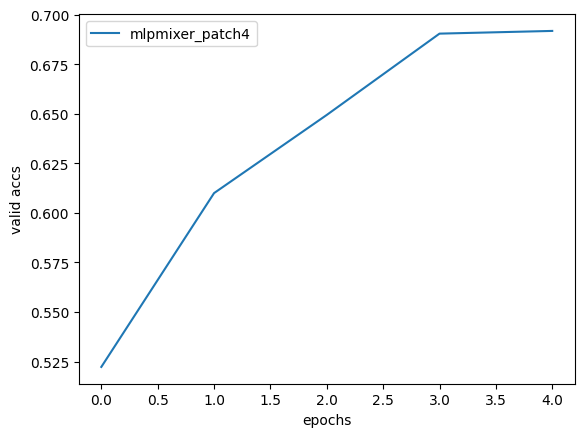

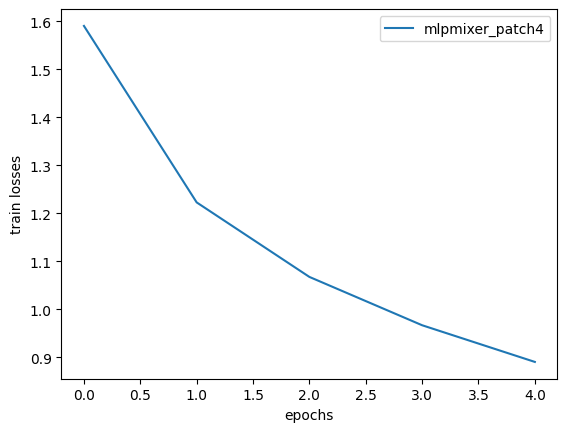

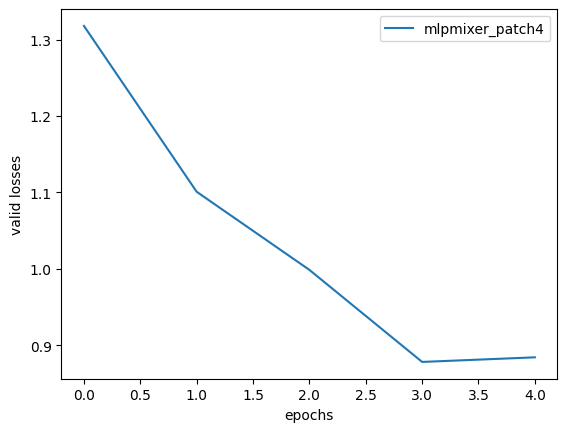

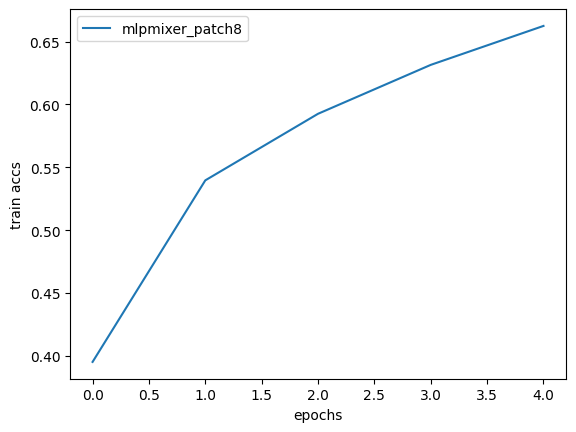

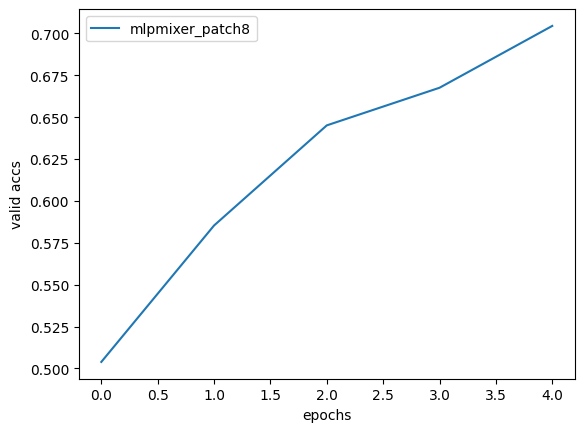

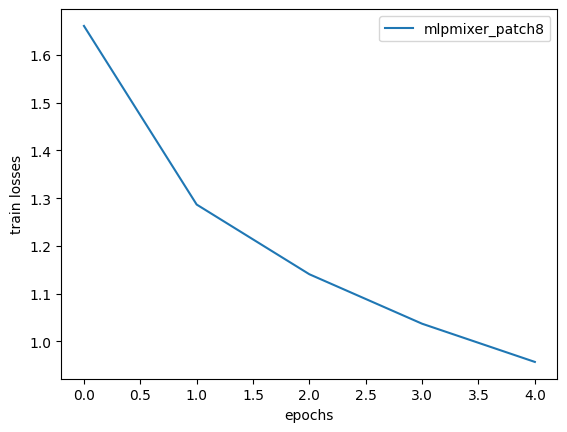

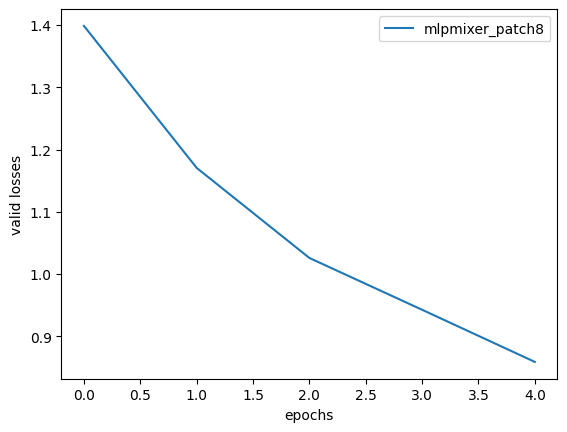

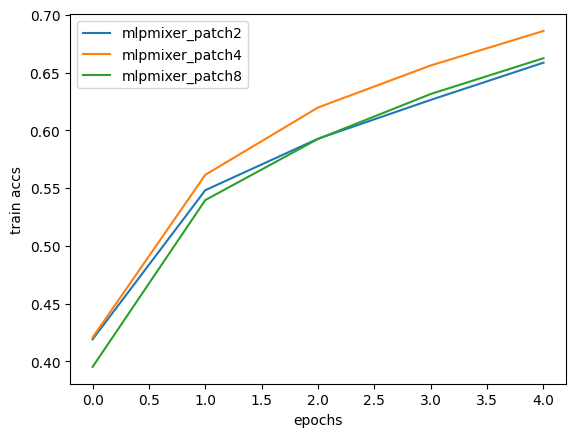

In [11]:
experiment3 = {
    "mlpmixer_patch2": Arguments(logdir="results/experiment3/mlpmixer_patch2", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch2.json', epochs=5),
    "mlpmixer_patch4": Arguments(logdir="results/experiment3/mlpmixer_patch4", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch4.json', epochs=5),
    "mlpmixer_patch8": Arguments(logdir="results/experiment3/mlpmixer_patch8", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch8.json', epochs=5)
}

run_experiment("experiment3_mlpmixer_patch_size", experiment3)


In [ ]:
!zip -r experiment3.zip results/experiment3

# Experiment 4

Find your best ResNet18 model by experimenting with different hyper-parameter choices. Provide the hyperparameters in your report. Visualize the kernels of the first layer, which has a weight of shape (out channel, in channel, kernel size, kernel size). You can modify the main.py or add extra cell in main.ipynb for visualization. Since we have 64 output channels and 3 input channels (RGB), one can view this as sixty-four 3 × 3 small images, where each image represent the kernel corresponding to that output channel. Note that this is an open-ended question. You can perform different pre-processing for visualization, e.g., standardizing the weight values, averaging across the channels to have gray scale images etc. You can see more details and examples in this blogpost. Please describe your visualization procedure in your report.

In [ ]:
# TODO

In [ ]:
!zip -r experiment4.zip results/experiment4

# Experiment 5

Set the patch size to be 4, and find hyper-parameters for your best MLPMixer model. Provide the full hyper-parameters in your report. Visualize the weights (only first layer) of token-mixing MLP in the first block as is described in Figure 5 of the MLPMixer paper. Comment and compare your results with the convolution visualizations. Explain what you think is the reason behind the success of the MLPMixer, especially over normal MLP?

In [ ]:
# TODO

In [ ]:
!zip -r experiment5.zip results/experiment5

# Experiment 6

Investigate how the width of the token-mixing and channel-mixing MLP layers affects the model’s generalization ability. Train the MLP-Mixer model with varying widths for the token-mixing and channel-mixing MLP layers (e.g., 256, 512, 1024). Compare the training and validation accuracies across different widths. Analyze how the capacity of the MLP layers impacts overfitting or underfitting.

In [ ]:
# TODO

In [ ]:
!zip -r experiment6.zip results/experiment6

# Experiment 7

Compare the gradient flow (e.g., norms of gradients at different layers) during backpropagation for all three architectures (MLP, ResNet18 and MLPMixer). Analyze and compare the behavior of gradients in each architecture.

In [ ]:
# TODO

In [ ]:
!zip -r experiment7.zip results/experiment7